In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid
from scipy import interpolate

from labellines import labelLine, labelLines

from centrex_tlf import states, hamiltonian, lindblad, couplings, transitions, utils
from centrex_tlf_julia_extension import lindblad_julia


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\julia\juliainfo.py:93: UserWarning: julia warned:
The latest version of Julia in the `release` channel is 1.11.1+0.x64.w64.mingw32. You currently have `1.10.4+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.1+0.x64.w64.mingw32 and update the `release` channel to that version.
  warnings.warn("{} warned:\n{}".format(julia, stderr))


In [2]:
plt.rcParams.update({"font.size": 15})

# Parameters

In [43]:
nprocs = 7  # number of processes to start, nprocs-1 do the actual calculation

laser_power0 = 0.0337  # max laser power in W of the first pass
laser_power1 = 0.013  # max laser power in W of the first pass
σlaser = 0.000914  # laser SD in m
power_loss_per_pass = (
    20.2 / 23.8
)  # ratio between first pass and second pass normally around ~0.944

npasses = 13
multipass_offset = 0.010  # offset in m
distance_between_passes = 0.03556 / npasses  # distance in m

intensity0 = laser_power0 / (2 * np.pi * σlaser * σlaser)
intensity1 = laser_power1 / (2 * np.pi * σlaser * σlaser)

xlocs = [
    (n - 1) * distance_between_passes + multipass_offset
    for n in utils.multipass.multipas_prism_order(npasses)
]
ylocs = npasses * [0.0]
ampl0 = [intensity0 * power_loss_per_pass**n for n in range(npasses)]
ampl1 = [intensity1 * power_loss_per_pass**n for n in range(npasses)]

δ_range = [1.6, -1.5, 20]
vz_range = [80, 250, 15]
y0_range = [-0.002, 0.002, 11]

vcm = 150.0
vcm_sigma = 30.0
vperp_sigma = 38.0

# System Setup

In [5]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.Q, J_ground=1, F1=1 / 2, F=0
    ),
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.Q, J_ground=1, F1=1 / 2, F=1
    ),
]

polarizations = [
    [couplings.polarization_Z, couplings.polarization_X, couplings.polarization_Y],
    [couplings.polarization_Z, couplings.polarization_X, couplings.polarization_Y],
]


In [6]:
transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
)


In [18]:
# ignore small decay to J=6
obe_system = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=True,
    decay_channels=lindblad.DecayChannel(
        1.0 * states.CoupledBasisState(None, None, None, None, None, None, v=1),
        states.QuantumSelector(J=1, electronic=states.ElectronicState.B),
        branching=1e-2,
    ),
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


In [19]:
odepars = lindblad_julia.odeParameters(
    Ω0="phase_modulation(t, β0, ωphase0) * (multipass_2d_rabi(vz*t, y0+vy*t, ampl0, xlocs, ylocs, σzlaser, σylaser, main_coupling0) + multipass_2d_rabi(vz*t, x0+vx*t, ampl0, xlocs, ylocs, σzlaser, σylaser, main_coupling0) )",
    δ0=0.0,  # detuning of the laser [rad/s]
    Ω1="phase_modulation(t, β1, ωphase1) * (multipass_2d_rabi(vz*t, y0+vy*t, ampl1, xlocs, ylocs, σzlaser, σylaser, main_coupling1) + multipass_2d_rabi(vz*t, x0+vx*t, ampl1, xlocs, ylocs, σzlaser, σylaser, main_coupling1) )",
    δ1=0.0,  # detuning of the laser [rad/s]
    σzlaser=σlaser,  # laser horizontal width [m]
    σylaser=σlaser,  # laser vertical width [m]
    # laser multipass parameters
    ampl0=ampl0,
    ampl1=ampl1,
    xlocs=xlocs,
    ylocs=ylocs,
    # laser phase modulation
    ωphase=0 * hamiltonian.Γ,  # laser phase modulation frequency [rad/s]
    β=3.8,  # laser phase modulation depth [rad]
    # laser polarization switching
    ωp0=0.65 * hamiltonian.Γ,  # polarization switching frequency [rad/s]
    φp0=0.0,  # polarization switching phase [rad]
    ωp1=2 * 0.65 * hamiltonian.Γ,  # polarization switching frequency [rad/s]
    φp1=0.0,  # polarization switching phase [rad]
    Pl0="sin(ωp0*t + φp0)",
    PZ0="(Pl0>-3/4) & (Pl0<=3/4)",
    PX0="Pl0<=-3/4",
    PY0="Pl0>3/4",
    Pl1="sin(ωp1*t + φp1)",
    PZ1="(Pl0>-3/4) & (Pl0<=3/4)",
    PX1="Pl1<=-3/4",
    PY1="Pl1>3/4",
    # molecules
    x0=0.0,  # molecule start x position [m]
    y0=0.0,  # molecule start y position [m]
    vx=0.0,  # molecule vx [m/s]
    vy=0.0,  # molecule vy [m/s]
    vz=150.0,  # longitudinal molecular velocity [m/s]
    main_coupling0=np.abs(obe_system.couplings[0].main_coupling),
    main_coupling1=np.abs(obe_system.couplings[1].main_coupling),
)

In [20]:
# on my home pc julia only loads on the third try, use try except in while loop to
# automatically retry
import logging

counter = 0
while True:
    try:
        # nprocs=7 because the 1st process is the manager, so with n cores use n+1
        obe_system = lindblad_julia.setup_OBE_system_julia(
            obe_system, transition_selectors, odepars, n_procs=nprocs
        )
    except Exception as e:
        counter += 1
        logging.warning(f"Catch exception {counter}")
        logging.error(e)
        if counter > 3:
            raise e
        continue
    break

In [21]:
df_branching = couplings.branching.generate_br_dataframe(
    obe_system.ground, obe_system.excited, group_ground="J"
)
df_branching

,"|B, J = 1, F₁ = 1/2, F = 0>","|B, J = 1, F₁ = 1/2, F = 1>"
states,,
"|X, J = 1>",1.0,0.999873
"|X, J = 3>",0.0,0.000127


# Single Trajectory

In [30]:
indices_J0 = states.QuantumSelector(
    J=0, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J1 = states.QuantumSelector(
    J=1, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J2 = states.QuantumSelector(
    J=2, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J3 = states.QuantumSelector(
    J=3, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J4 = states.QuantumSelector(
    J=4, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J5 = states.QuantumSelector(
    J=5, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_excited = states.QuantumSelector(
    electronic=states.ElectronicState.B
).get_indices(obe_system.QN)
indices_vibrational = np.where([qn.largest.v == 1 for qn in obe_system.QN])[0]

In [24]:
indices_coupled = []
for cpl in obe_system.couplings:
    for c in cpl.fields:
        idg = np.nonzero(np.triu(c.field))[0]
        indices_coupled.extend(idg)
indices_coupled = np.unique(indices_coupled)

ρ = utils.population.generate_uniform_population_state_indices(
    indices_coupled, levels=len(obe_system.QN)
)

In [25]:
save_idxs = utils.population.get_diagonal_indices_flattened(
    size=len(obe_system.QN), mode="julia"
)

# stop simulation when the molecules reach the end of the multipass

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 260e-6))
config = lindblad_julia.OBEProblemConfig(
    saveat=1e-6, reltol=1e-3, abstol=1e-7, save_everystep=True, callback=None
)

In [26]:
results = lindblad_julia.do_simulation_single(problem, config=config)

# photons = 89.8


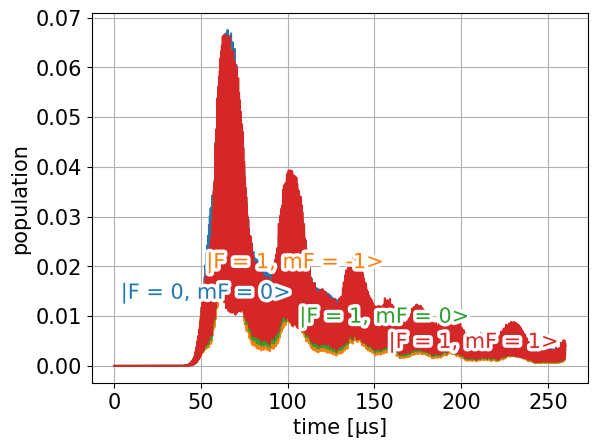

In [27]:
labels = [
    obe_system.QN[idx].largest.state_string_custom(["F", "mF"])
    for idx in indices_excited
]

fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_excited].T, label=labels)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

labelLines(ax.get_lines(), zorder=2.5, align=False)

ax.grid()

photons = (
    trapezoid(results.y[indices_excited].sum(axis=0).real, x=results.t) * hamiltonian.Γ
)

print(f"# photons = {photons:.1f}")

# photons = 89.8
rate = 3.45e+05 /s


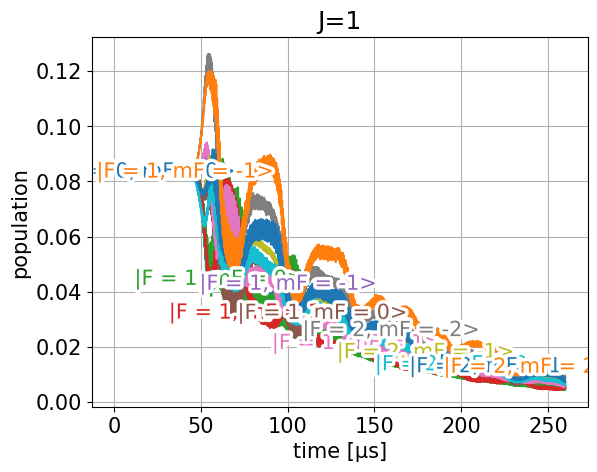

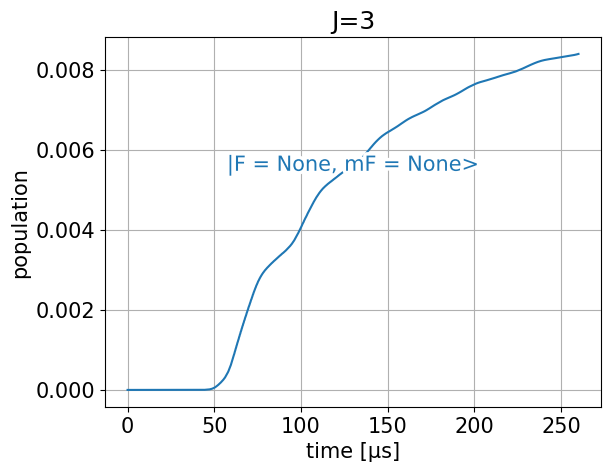

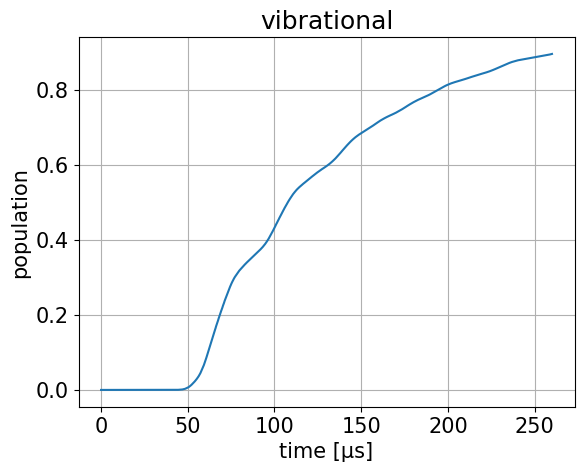

In [34]:
for J, ind in enumerate(
    [indices_J0, indices_J1, indices_J2, indices_J3, indices_J4, indices_J5]
):
    if len(ind) == 0:
        continue
    labels = [
        obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in ind
    ]

    fig, ax = plt.subplots()
    ax.plot(results.t * 1e6, results.y[ind].T, label=labels)

    ax.set_title(f"J={J}")
    ax.set_xlabel("time [μs]")
    ax.set_ylabel("population")

    labelLines(ax.get_lines(), zorder=2.5, align=False)

    ax.grid()

for ind in [indices_vibrational]:
    if len(ind) == 0:
        continue
    labels = [
        obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in ind
    ]

    fig, ax = plt.subplots()
    ax.plot(results.t * 1e6, results.y[ind].T, label=labels)

    ax.set_title(f"vibrational")
    ax.set_xlabel("time [μs]")
    ax.set_ylabel("population")

    ax.grid()


photons = (
    trapezoid(results.y[indices_excited].sum(axis=0).real, x=results.t) * hamiltonian.Γ
)

print(f"# photons = {photons:.1f}")
print(f"rate = {photons/problem.tspan[-1]:.2e} /s")

# Trajectories without EOM

In [35]:
δls = (
    np.append(np.append(-np.logspace(*δ_range), [0]), np.logspace(*δ_range)[::-1])
    * hamiltonian.Γ
)
vzs = np.linspace(*vz_range)
y0s = np.linspace(*y0_range)

parameters = ["vz", "δ0", "δ1", "x0", "y0"]
parameter_values = [
    vzs,
    δls,
    δls,
    y0s,
    y0s,
]

In [36]:
save_idxs_excited = [
    v.item()
    for v in utils.population.get_diagonal_indices_flattened(
        size=len(obe_system.QN), states=indices_excited, mode="julia"
    )
]


In [37]:
output_function = lindblad_julia.setup_state_integral_calculation_state_idxs(
    nphotons=True, Γ=hamiltonian.Γ
)

callback_function = lindblad_julia.setup_discrete_callback_terminate(
    odepars, "vz*t >= 50e-3"
)

In [38]:
problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 1000e-6))

ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()",
    distributed_method="EnsembleDistributed()",
    save_everystep=True,
    save_idxs=save_idxs_excited,
    callback=callback_function,
    reltol=1e-4,
    abstol=1e-7,
    saveat=1e-7,
)

ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=parameter_values,
    output_func=output_function,
    zipped=False,
)

lindblad_julia.setup_problem_parameter_scan(
    ensemble_problem,
)

In [ ]:
lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)

In [ ]:
results_scan = lindblad_julia.get_results_parameter_scan(ensemble_problem)

# Trajectories with EOM